Visualization example of a very simple two-dimensional classification problem.

The positive class is defined as 8 points equally spaces around a circle with radius 1 and center (3,2).

The negative class is defined as 8 points equally spaced around a circle with radius 3 and center (3,2).

The problem is designed to force a quadratic SVM into learning the decision boundary (x0 - 3)^2 + (x1 - 2)^2 = 5.

We can from this very simple decision function calculate how the decision value is affected by a unit change in any feature and plot the decision surface, boundary and the components of the decision function for points along a line intersecting the decision boundary.

In [47]:
import numpy as np

from explainpolysvm import expsvm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


In [48]:
save_figs = False

In [49]:
n_train_per_class = 8

# Radii for rings
r1 = 1.
r2 = 3.
center = np.array([3,2])

# Sample from classes
phi_train1 = 2 * np.pi * np.arange(0, 1, 1/n_train_per_class)#np.random.rand(n_train_per_class)
r_train1 = r1
X_train1 = center +np.multiply(r1, np.transpose(np.array((np.cos(phi_train1), np.sin(phi_train1)))))

phi_train2 = 2 * np.pi * np.arange(0, 1, 1/n_train_per_class)#np.random.rand(3*n_train_per_class)
X_train2 = center + np.multiply(r2, np.transpose(np.array((np.cos(phi_train2), np.sin(phi_train2)))))

X = np.concatenate((X_train1, X_train2), axis=0)
# y = np.concatenate((np.ones(n_train_per_class), -np.ones(n_train_per_class)))
y = np.concatenate((np.ones(len(X_train1)), -np.ones(len(X_train2))))
# y = [-1, -1, -1, 1, 1, 1]

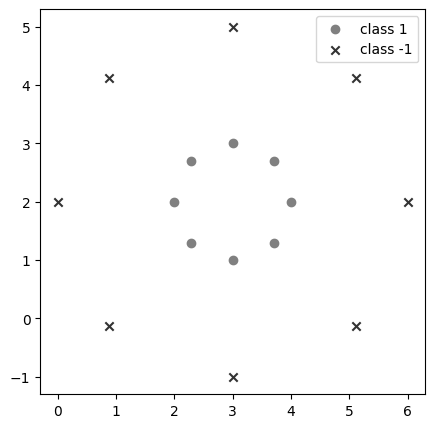

In [50]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(x=X_train1[:,0], y=X_train1[:,1], color=[0.5, 0.5, 0.5])
ax.scatter(x=X_train2[:,0], y=X_train2[:,1], color=[0.2, 0.2, 0.2], marker='x')
ax.set_aspect('equal', adjustable='box')
plt.legend(['class 1', 'class -1'])
if save_figs:
    plt.savefig('./images/training_data_2d.png', dpi=200,facecolor='white')
plt.draw()

In [51]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, random_state=10)
X_train, y_train = X, y
# Fit SVM
C = 10
degree = 2
gamma = 'scale'
r = 1*np.sqrt(2)

# Fit SVM
kernel = 'poly'
model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, coef0=r)
model.fit(X_train, y_train)

sv = model.support_vectors_
dual_coef = np.squeeze(model.dual_coef_)
intercept = model.intercept_[0]
kernel_gamma = model._gamma

es = expsvm.ExPSVM(sv=sv, dual_coef=dual_coef, intercept=intercept,
                kernel_d=degree, kernel_r=r, kernel_gamma=kernel_gamma)
es.transform_svm()

Feature importance

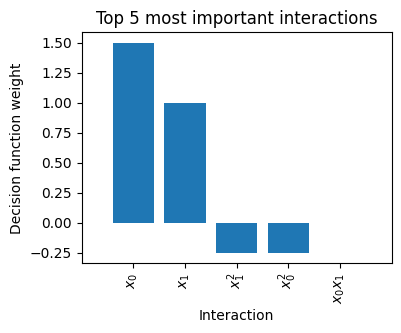

In [53]:
_ = es.plot_model_bar(n_features=20, magnitude=False, show=False, figsize=(4,3))
if save_figs:
    plt.savefig('./images/feature_importance_2d.png', dpi=200, facecolor='white')
plt.show()

In [209]:
# Function to calculate the roots of a quadratic function.
def calc_boundary_for_2d_sv_with_2_features(x, is_x0, feat_imp, decimals: int = None):
    """Calcuate the roots of a two-dimensional quadratic (or linear) function.
    """
    a = feat_imp[0][np.where(feat_imp[1] == 'intercept')[0][0]]
    if is_x0:
        b = feat_imp[0][np.where(feat_imp[1] == '0')[0][0]]
        c = feat_imp[0][np.where(feat_imp[1] == '1')[0][0]]
        d = feat_imp[0][np.where(feat_imp[1] == '1,1')[0][0]]
        e = feat_imp[0][np.where(feat_imp[1] == '0,0')[0][0]]
    else:
        c = feat_imp[0][np.where(feat_imp[1] == '0')[0][0]]
        b = feat_imp[0][np.where(feat_imp[1] == '1')[0][0]]
        e = feat_imp[0][np.where(feat_imp[1] == '1,1')[0][0]]
        d = feat_imp[0][np.where(feat_imp[1] == '0,0')[0][0]]
    f = feat_imp[0][np.where(feat_imp[1] == '0,1')[0][0]]

    if decimals is not None:
        a = np.round(a, decimals)
        b = np.round(b, decimals)
        c = np.round(c, decimals)
        d = np.round(d, decimals)
        e = np.round(e, decimals)
        f = np.round(f, decimals)

    sqrt_content = (c + f*x)**2 - 4*d*(a + x*(b + e*x))
    # print(sqrt_content)
    x1_p, x1_m = np.nan, np.nan
    if d != 0:
        if sqrt_content >=-np.inf:
            x1_p = -(c + f*x + np.sqrt(sqrt_content))/(2*d)
            x1_m = -(c + f*x - np.sqrt(sqrt_content))/(2*d)
    else:
        if c + f*x != 0:
            x1_p = - (a + x*(b + e*x))/(c + f*x)
            x1_m = np.nan
            
    return [x1_p, x1_m]

def calc_x0(x1):
    return 3 + np.sqrt(5 - (x1-2)**2), 3 - np.sqrt(5 - (x1-2)**2)


In [238]:
# Define a region for  plotting the decision surface
n_step = 201
x0_min = -1
x0_max = 7
x1_min = -2
x1_max = 6
x0_space = np.linspace(x0_min, x0_max, n_step)
x1_space = np.linspace(x1_min, x1_max, n_step)
x0_grid, x1_grid = np.meshgrid(x0_space, x1_space)
# x_grid = x_grid.flatten()\\\
# x1_grid = x1_grid.flatten()\\\
x0x1_grid = np.concatenate((x0_grid.flatten()[:, np.newaxis], x1_grid.flatten()[:, np.newaxis]), axis=1)
y_pred = es.decision_function(x0x1_grid)

f = es.feature_importance(format_names=False, include_intercept=True, magnitude=False)

x1_boundary = np.array([calc_boundary_for_2d_sv_with_2_features(x0_b, True, f, 3) for x0_b in x0_space])
x0_boundary = np.array([calc_boundary_for_2d_sv_with_2_features(x1_b, False, f, 3) for x1_b in x1_space])


C:\Users\Rikard\AppData\Local\Temp\ipykernel_10700\3923149823.py:30: RuntimeWarning: invalid value encountered in sqrt
  x1_p = -(c + f*x + np.sqrt(sqrt_content))/(2*d)
C:\Users\Rikard\AppData\Local\Temp\ipykernel_10700\3923149823.py:31: RuntimeWarning: invalid value encountered in sqrt
  x1_m = -(c + f*x - np.sqrt(sqrt_content))/(2*d)


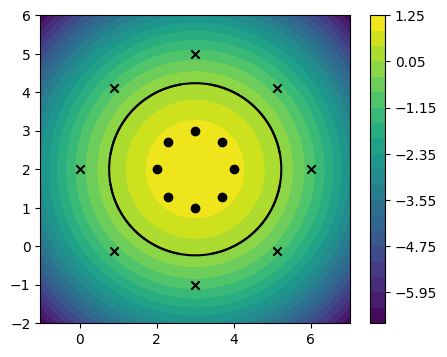

In [239]:
# Plot decision surface
fig, ax = plt.subplots(1,1, figsize=(5,4))
delta = (np.max(y_pred) - np.min(y_pred))/20
cmap = ax.contourf(x0_grid, x1_grid, y_pred.reshape((n_step, n_step)), 
                   levels=np.arange(np.min(y_pred), np.max(y_pred)+delta, delta))

ax.scatter(x=X_train1[:,0], y=X_train1[:,1], color='k', marker='o')
ax.scatter(x=X_train2[:,0], y=X_train2[:,1], color='k', marker='x')

plt.plot(x0_space, x1_boundary[:, 0], 'k')
plt.plot(x0_space, x1_boundary[:, 1], 'k')
plt.plot(x0_boundary[:, 0], x1_space, 'k')
plt.plot(x0_boundary[:, 1], x1_space, 'k')

ax.set_aspect('equal', adjustable='datalim')
# plt.legend(['class 1', 'class -1', 'decision boundary'])
plt.colorbar(cmap, ax=ax)
plt.xlim([x0_min, x0_max])
plt.ylim([x1_min, x1_max])
plt.show()

In [245]:
feat_imp = es.feature_importance(magnitude=False, format_names=False)
print('Interaction\tvalue')
for fi in zip(*feat_imp):
    print(f'{fi[1]}:\t{fi[0]:.7f}')

Interaction	value
intercept:	-1.9996013
0:	1.4997788
1:	1.0000196
1,1:	-0.2500242
0,0:	-0.2499748
0,1:	0.0000150


The two concentric circles are centered on (3,2) and the decision function is $f(x_0, x_1) = -2 + 1.5x_0 + 1x_1 - 0.25x_0^2 - 0.25x_1^2 = -0.25((x_0 - 3)^2 + (x_1 - 2)^2 - 5)$. 

For $f(x_0, x_1) = 0$ we find that the decision boundary is $(x_0 - 3)^2 + (x_1 - 2)^2 = 5$.

Maximum decision function value is reached at (3,2), we reach zero, for example at (1,2) and all other point along the circle.

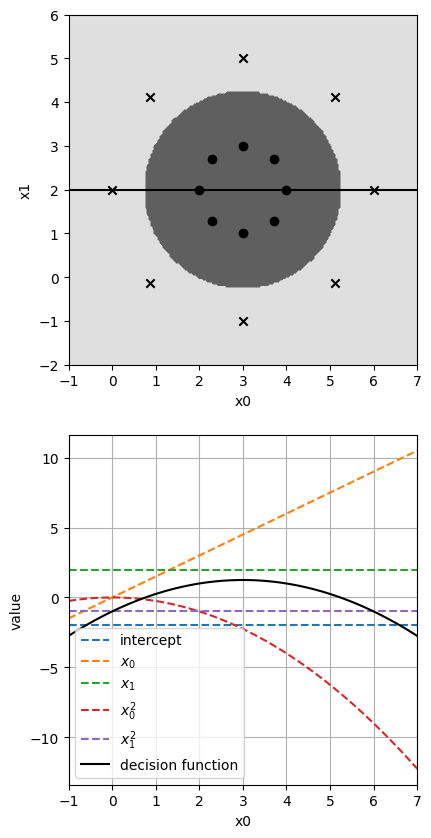

In [232]:
# Plot line over the decision surface as well as the decision function components along this line.
# The line has function x1=2

fig, ax = plt.subplots(2, 1, figsize=(4.5, 10))
cmap = ax[0].contourf(x0_grid, x1_grid, 
                    (y_pred>0).reshape((n_step, n_step)).astype(float)
                    -(y_pred<0).reshape((n_step, n_step)).astype(float), 
                    cmap='binary', levels=[-2, -1, 0, 1, 2])
ax[0].scatter(x=X_train1[:,0], y=X_train1[:,1], color='k', marker='o')
ax[0].scatter(x=X_train2[:,0], y=X_train2[:,1], color='k', marker='x')
ax[0].set_aspect('equal', adjustable='datalim')
# plt.legend(['class 1', 'class -1', 'decision boundary'])

# Plot line
line_min = -1
line_max = 7
x0s = np.arange(line_min, line_max+0.1, 0.1)[:,np.newaxis]
x1s = 2*np.ones(x0s.shape)
xs = np.concatenate([x0s, x1s], axis=1)
feat_imp = np.zeros((len(xs), len(feat_order)))

ax[0].plot(x0s, x1s, color='k')
# cmap.clim([-1.5, 1.5])
ax[0].set_xlabel('x0')
ax[0].set_ylabel('x1')

# Calculate decision function components along line
for ind, xy in enumerate(xs):
    imp = es.decision_function_components(xy, include_intercept=True, output_interaction_names=True, format_interaction_names=True)
    for find, f in enumerate(feat_order):
        feat_imp[ind, find] = imp[0][0, np.where(np.array(imp[1]) == f)[0][0]]

# Plot components
ax[1].plot(x0s, feat_imp, ls='--')
ax[1].plot(x0s, np.sum(feat_imp, axis=1), color='k')
ax[1].legend(['intercept' if f == '' else f for f in feat_order] + ['decision function'])
ax[1].set_xlabel('x0')
ax[1].set_ylabel('value')
ax[1].set_xlim(ax[0].get_xlim())
ax[1].grid()

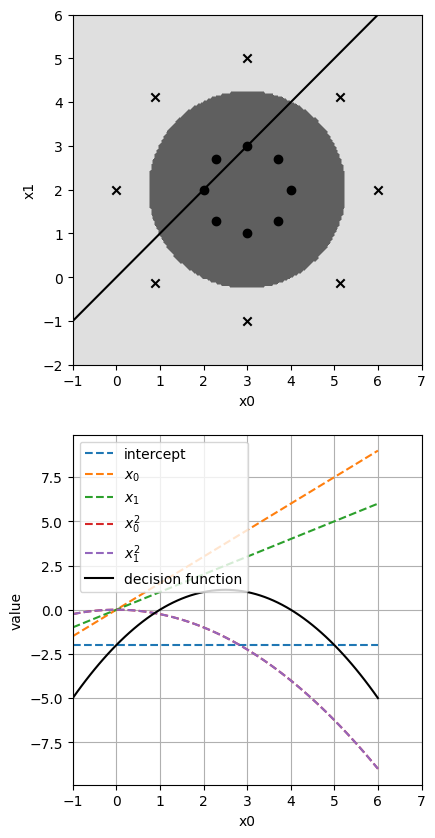

In [247]:
# Plot line over the decision surface as well as the decision function components along this line.
# The line is x1=x0

fig, ax = plt.subplots(2, 1, figsize=(4.5, 10))
cmap = ax[0].contourf(x0_grid, x1_grid, 
                    (y_pred>0).reshape((n_step, n_step)).astype(float)
                    -(y_pred<0).reshape((n_step, n_step)).astype(float), 
                    cmap='binary', levels=[-2, -1, 0, 1, 2])
# plt.colorbar(cmap)
ax[0].scatter(x=X_train1[:,0], y=X_train1[:,1], color='k', marker='o')
ax[0].scatter(x=X_train2[:,0], y=X_train2[:,1], color='k', marker='x')
ax[0].set_aspect('equal', adjustable='datalim')
# plt.legend(['class 1', 'class -1', 'decision boundary'])

# Plot line
line_min = -1
line_max = 6
x0s = np.arange(line_min, line_max+0.1, 0.1)[:,np.newaxis]
x1s = x0s
xs = np.concatenate([x0s, x1s], axis=1)
feat_imp = np.zeros((len(xs), len(feat_order)))
ax[0].plot(x0s, x1s, color='k')
ax[0].set_xlabel('x0')
ax[0].set_ylabel('x1')

# Calculate decision function components along line
for ind, xy in enumerate(xs):
    imp = es.decision_function_components(xy, include_intercept=True, output_interaction_names=True, format_interaction_names=True)
    for find, f in enumerate(feat_order):
        feat_imp[ind, find] = imp[0][0, np.where(np.array(imp[1]) == f)[0][0]]

# Plot components
ax[1].plot(x0s, feat_imp, ls='--')
ax[1].plot(x0s, np.sum(feat_imp, axis=1), color='k')
ax[1].legend(['intercept' if f == '' else f for f in feat_order] + ['decision function'])
ax[1].set_xlabel('x0')
ax[1].set_ylabel('value')
xlim = ax[0].get_xlim()
ax[1].set_xlim(xlim)
ax[1].grid()